In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
import gc  # for memory cleanup
from tqdm import tqdm
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# %% visualization functions
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # yellow with transparency
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4) Batchfähig, also mehrere Boxen gleichzeitig möglich

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
    low_res_pred = F.interpolate(
        low_res_pred, size=(H, W), mode="bilinear", align_corners=False
    )  # (1, 1, H, W)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (H, W)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# %% Automatische Normalisierungsfunktion
def normalize_image_auto(image):
    """
    Normalisiert ein Bild automatisch:
    - Clipping für CT-Daten (große Maximalwerte)
    - Min-Max-Normalisierung bei großen Bereichen
    - Division durch 255 bei kleinen Bereichen
    """
    max_val = image.max()
    min_val = image.min()

    if max_val > 2000:  # Schwellenwert für typische CT-Daten
        logging.info(f"Clipping angewendet: Ursprünglicher Maximalwert = {max_val}")
        image = np.clip(image, -1000, 1000)
        max_val = image.max()
        min_val = image.min()

    if max_val - min_val > 255 or max_val > 255:
        normalized = (image - min_val) / (max_val - min_val + 1e-8)
        logging.info(f"Min-Max-Normalisierung angewendet: Min={min_val}, Max={max_val}")
    else:
        normalized = image / 255.0
        logging.info(f"Division durch 255 angewendet: Max={max_val}")

    return normalized

# %% Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# %% Modell laden
MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"  # path to the checkpoint
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
logging.info("MedSAM model loaded successfully.")

# %% Calculate total number of slices
def calculate_total_slices(images_dir):
    total_slices = 0
    for image_file in os.listdir(images_dir):
        image_path = os.path.join(images_dir, image_file)
        if not image_file.endswith(".nii") and not image_file.endswith(".nii.gz"):
            continue
        nifti_image = nib.load(image_path)
        total_slices += nifti_image.shape[2]  # Z-Achse
    return total_slices

# %% Optimized segmentation with progress display and logging
def process_images_and_masks_with_resume(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    """
    Continues segmentation starting from a specific file and slice.
    """
    resume = resume_file is None

    mask_files = sorted(os.listdir(masks_dir))  # Ensure alphabetical order

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True

            if not resume:
                progress.update(1)
                continue

            # Upload medical image and mask
            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)

            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()

            total_slices = image_data.shape[2]
            slice_start = resume_slice if mask_file == resume_file and resume_slice is not None else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as slice_progress:
                for slice_idx in range(slice_start, total_slices):
                    logging.info(f"Process Slice {slice_idx} for file {mask_file}")
                    image_slice = image_data[:, :, slice_idx]
                    mask_slice = mask_data[:, :, slice_idx]

                    if np.sum(mask_slice) == 0:
                        slice_progress.update(1)
                        continue

                    # Bounding Box from Mask
                    non_zero_coords = np.argwhere(mask_slice > 0)
                    y_min, x_min = non_zero_coords.min(axis=0)
                    y_max, x_max = non_zero_coords.max(axis=0)
                    box_np = np.array([[x_min, y_min, x_max, y_max]])

                    # preprocessing of the image
                    H, W = image_slice.shape
                    resized_image = transform.resize(
                        image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
                    normalized_image = normalize_image_auto(resized_image)
                    image_rgb = np.stack([normalized_image] * 3, axis=-1)

                    box_1024 = box_np / np.array([W, H, W, H]) * 1024
                    image_tensor = torch.tensor(image_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)

                    # MedSAM inference
                    with torch.no_grad():
                        image_embedding = medsam_model.image_encoder(image_tensor)
                        medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, 1024, 1024)

                    # Save results
                    visualization_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                    seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(resized_image, cmap="gray")
                    show_box(box_1024[0], ax[0])
                    ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Box")
                    ax[1].imshow(resized_image, cmap="gray")
                    show_mask(medsam_seg, ax[1])
                    ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                    plt.savefig(visualization_file)
                    plt.close(fig)

                    plt.imsave(seg_file, medsam_seg, cmap="gray")

                    # clean memory
                    del image_tensor, image_embedding, medsam_seg
                    gc.collect()

                    slice_progress.update(1)

            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# %% Directories and start
images_dir = "data/Heart/output_images"
masks_dir = "data/Heart/output_masks"
output_dir = "data/Heart/segmentation_automatisch_normalization_results"
os.makedirs(output_dir, exist_ok=True)

process_images_and_masks_with_resume(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="la_026.nii.gz",
    resume_slice=50
)


2025-04-30 14:11:23,163 - INFO - Verwende Gerät: cpu
C:\Users\rawan\AppData\Local\Programs\Python\Python311\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

In [2]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken
mask_png_folder = os.path.join("data", "Heart", "output_masks_updated")
segmentation_results_folder = os.path.join("data", "Heart", "segmentation_automatisch_normalization_results")

# Funktion zur Berechnung des Dice Scores
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0  # Sonderfall: Beide Masken sind komplett leer
    dice = (2. * intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

# Funktion zur Verarbeitung einer einzelnen Datei
def process_single_file(mask_filename):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    slice_number_converted = int(slice_number) - 1
    segmentation_filename = f"{base_name}.nii.gz_slice_{slice_number_converted}_segmentation.png"

    mask_png_path = os.path.join(mask_png_folder, mask_filename)
    segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)

    if os.path.exists(segmentation_path):
        try:
            # Masken laden
            mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
            segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

            # Sicherstellen, dass beide Masken binär sind (0 und 1)
            mask_png = (mask_png > 0).astype(np.uint8)
            segmentation = (segmentation > 0).astype(np.uint8)

            # Dice Score berechnen
            dice = dice_score(mask_png, segmentation)
            logging.info(f"{mask_filename}: Dice Score = {dice:.4f}")
            return mask_filename, dice
        except Exception as e:
            logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
            return None
    else:
        logging.warning(f"Segmentationsdatei für {mask_filename} nicht gefunden!")
        return None

# Parallelisierte Verarbeitung
dice_scores = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, mask_filename) for mask_filename in os.listdir(mask_png_folder) if mask_filename.endswith(".png")]
    dice_scores = [future.result() for future in futures if future.result() is not None]


2025-04-30 15:05:19,208 - INFO - la_003_slice_04_segmentation.png: Dice Score = 0.6331
2025-04-30 15:05:19,243 - INFO - la_003_slice_08_segmentation.png: Dice Score = 0.3183
2025-04-30 15:05:19,246 - INFO - la_003_slice_03_segmentation.png: Dice Score = 0.7315
2025-04-30 15:05:19,281 - INFO - la_003_slice_05_segmentation.png: Dice Score = 0.4549
2025-04-30 15:05:19,283 - INFO - la_003_slice_07_segmentation.png: Dice Score = 0.3892
2025-04-30 15:05:19,287 - INFO - la_003_slice_06_segmentation.png: Dice Score = 0.4465
2025-04-30 15:05:19,296 - INFO - la_003_slice_01_segmentation.png: Dice Score = 0.2794
2025-04-30 15:05:19,296 - INFO - la_003_slice_02_segmentation.png: Dice Score = 0.5911
2025-04-30 15:05:19,337 - INFO - la_003_slice_09_segmentation.png: Dice Score = 0.2855
2025-04-30 15:05:19,443 - INFO - la_003_slice_15_segmentation.png: Dice Score = 0.7786
2025-04-30 15:05:19,452 - INFO - la_003_slice_10_segmentation.png: Dice Score = 0.2755
2025-04-30 15:05:19,462 - INFO - la_003_sli

2025-04-30 15:05:58,950 - INFO - 
Durchschnittlicher Dice Score: 0.7599


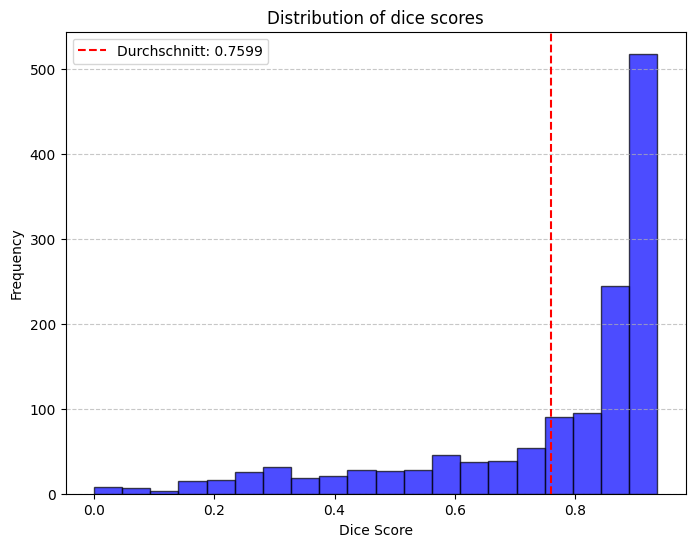

In [3]:
# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    with open("data\Heart\dice_scores.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of dice scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern und anzeigen
    plt.savefig('data\Heart\dice_score_automatisch_histogram.png')
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")


In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from scipy.ndimage import label
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
from tqdm import tqdm
import logging
import gc  # für Speicherbereinigung

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierungsfunktionen
def show_mask(mask, ax, random_color=False):
    color = np.random.rand(3) if random_color else np.array([251/255, 252/255, 30/255])
    mask_img = np.zeros((*mask.shape, 4))
    mask_img[mask > 0] = np.append(color, 0.6)
    ax.imshow(mask_img)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor="none", lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024[None, :], dtype=torch.float, device=img_embed.device)
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    return (low_res_pred > 0.5).astype(np.uint8)

# Bounding Box Finder (mehrere Boxen)
def get_multiple_bounding_boxes(mask_slice):
    labeled_mask, num_features = label(mask_slice > 0)
    boxes = []
    for i in range(1, num_features + 1):
        coords = np.argwhere(labeled_mask == i)
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        boxes.append([x_min, y_min, x_max, y_max])
    return boxes

# Verarbeitung
def process_images_and_masks(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    os.makedirs(output_dir, exist_ok=True)
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as file_bar:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_filename = mask_file.replace("label_", "rec_").replace(".nii.gz", ".nii.gz")
            image_path = os.path.join(images_dir, image_filename)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild: {image_filename}")
                file_bar.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                file_bar.update(1)
                continue

            image = nib.load(image_path).get_fdata()
            mask = nib.load(mask_path).get_fdata()
            total_slices = image.shape[2]
            start_slice = resume_slice if mask_file == resume_file and resume_slice else 0

            with tqdm(total=total_slices - start_slice, desc=f"{mask_file}", unit="Slice") as slice_bar:
                for idx in range(start_slice, total_slices):
                    img_slice = image[:, :, idx]
                    mask_slice = mask[:, :, idx]

                    if np.sum(mask_slice) == 0:
                        slice_bar.update(1)
                        continue

                    boxes = get_multiple_bounding_boxes(mask_slice)
                    if not boxes:
                        slice_bar.update(1)
                        continue

                    H, W = img_slice.shape
                    resized = transform.resize(img_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
                    # norm = (resized - resized.min()) / max(resized.max() - resized.min(), 1e-8)
                    norm = resized / 255.0
                    img_rgb = np.stack([norm]*3, axis=-1)
                    img_tensor = torch.tensor(img_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)
                    box_array = np.array(boxes) / np.array([W, H, W, H]) * 1024

                    with torch.no_grad():
                        embedding = medsam_model.image_encoder(img_tensor)
                        combined = np.zeros((1024, 1024), dtype=np.uint8)
                        for box in box_array:
                            seg = medsam_inference(medsam_model, embedding, box, 1024, 1024)
                            combined = np.maximum(combined, seg)

                    # Speichern
                    vis_path = os.path.join(output_dir, f"{mask_file}_slice_{idx}_vis.png")
                    seg_path = os.path.join(output_dir, f"{mask_file}_slice_{idx}_seg.png")

                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(resized, cmap="gray")
                    for box in box_array:
                        show_box(box, ax[0])
                    ax[0].set_title(f"Slice {idx} mit Boxen")

                    ax[1].imshow(resized, cmap="gray")
                    show_mask(combined, ax[1])
                    ax[1].set_title("Segmentierung")

                    plt.savefig(vis_path)
                    plt.close(fig)
                    plt.imsave(seg_path, combined, cmap="gray")

                    del img_tensor, embedding, combined
                    gc.collect()
                    slice_bar.update(1)
            file_bar.update(1)

# Geräte und Modell laden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwendetes Gerät: {device}")

MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH).to(device).eval()

# Starte Verarbeitung
process_images_and_masks(
    images_dir="data/upper_airways/filtered_images",
    masks_dir="data/upper_airways/filtered_masks",
    output_dir="data/upper_airways/segmentation_results",
    resume_file="label_29.nii.gz",
    resume_slice=0
)


2025-04-30 17:08:50,276 - INFO - Verwende Gerät: cpu
C:\Users\rawan\AppData\Local\Programs\Python\Python311\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

UnboundLocalError: cannot access local variable 'seg' where it is not associated with a value

In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
import gc
from tqdm import tqdm
import logging

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# %% Visualisierungsfunktionen
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

def get_bounding_boxes_from_mask(mask):
    labeled_mask = label(mask)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# %% Gerät definieren
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# %% Modell laden
MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
logging.info("MedSAM Modell erfolgreich geladen.")

# %% Segmentierung mit Wiederaufnahme und mehreren Boxen
def process_images_and_masks_with_resume(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()
            total_slices = image_data.shape[2]
            slice_start = resume_slice if mask_file == resume_file and resume_slice is not None else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as slice_progress:
                for slice_idx in range(slice_start, total_slices):
                    logging.info(f"Verarbeite Slice {slice_idx} für Datei {mask_file}")
                    image_slice = image_data[:, :, slice_idx]
                    mask_slice = mask_data[:, :, slice_idx]

                    if np.sum(mask_slice) == 0:
                        slice_progress.update(1)
                        continue

                    boxes = get_bounding_boxes_from_mask(mask_slice)
                    H, W = image_slice.shape
                    resized_image = transform.resize(image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
                    # normalized_image = (resized_image - resized_image.min()) / max(resized_image.max() - resized_image.min(), 1e-8)
                    normalized_image = resized_image / 255.0
                    image_rgb = np.stack([normalized_image] * 3, axis=-1)
                    image_tensor = torch.tensor(image_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)

                    with torch.no_grad():
                        image_embedding = medsam_model.image_encoder(image_tensor)
                        combined_seg = np.zeros((1024, 1024), dtype=np.uint8)

                        for box in boxes:
                            box_np = np.array([box])
                            box_1024 = box_np / np.array([W, H, W, H]) * 1024
                            medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, 1024, 1024)
                            combined_seg = np.maximum(combined_seg, medsam_seg)

                    visualization_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                    seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(resized_image, cmap="gray")
                    for box in boxes:
                        box_1024 = np.array(box) / np.array([W, H, W, H]) * 1024
                        show_box(box_1024, ax[0])
                    ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")
                    ax[1].imshow(resized_image, cmap="gray")
                    show_mask(combined_seg, ax[1])
                    ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                    plt.savefig(visualization_file)
                    plt.close(fig)

                    plt.imsave(seg_file, combined_seg, cmap="gray")

                    del image_tensor, image_embedding, medsam_seg
                    gc.collect()
                    slice_progress.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            progress.update(1)

# %% Verzeichnisse definieren und starten
images_dir = "data/Heart/output_images"
masks_dir = "data/Heart/output_masks"
output_dir = "data/Heart/segmentation_2_results"
os.makedirs(output_dir, exist_ok=True)

process_images_and_masks_with_resume(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="la_024.nii.gz",
    resume_slice=0
)


2025-05-06 18:41:55,723 - INFO - Verwende Gerät: cpu
2025-05-06 18:42:00,607 - INFO - MedSAM Modell erfolgreich geladen.
Slices in la_024.nii.gz:   0%|                                                               | 0/70 [00:00<?, ?Slice/s]2025-05-06 18:42:01,080 - INFO - Verarbeite Slice 0 für Datei la_024.nii.gz

Slices in la_024.nii.gz:   1%|▊                                                      | 1/70 [00:21<24:14, 21.08s/Slice]2025-05-06 18:42:22,163 - INFO - Verarbeite Slice 1 für Datei la_024.nii.gz

Slices in la_024.nii.gz:   3%|█▌                                                     | 2/70 [00:42<24:01, 21.20s/Slice]2025-05-06 18:42:43,455 - INFO - Verarbeite Slice 2 für Datei la_024.nii.gz

Slices in la_024.nii.gz:   4%|██▎                                                    | 3/70 [01:03<23:24, 20.97s/Slice]2025-05-06 18:43:04,150 - INFO - Verarbeite Slice 3 für Datei la_024.nii.gz

Slices in la_024.nii.gz:   6%|███▏                                                   | 4/70 [01

In [ ]:
# -*- coding: utf-8 -*-
import os
import json
import time
import gc
import logging
import csv
from typing import Optional, Tuple

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
from tqdm import tqdm

# ============================================================
# Logging
# ============================================================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ============================================================
# Visualisierung
# ============================================================
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

def get_bounding_boxes_from_mask(mask):
    labeled_mask = label(mask)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes

# ============================================================
# MedSAM Inferenz
# ============================================================
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None, boxes=box_torch, masks=None
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    low_res_pred = low_res_pred.squeeze().detach().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# ============================================================
# Device + Modell
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"  # ggf. anpassen
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device).eval()
logging.info("MedSAM Modell erfolgreich geladen.")

# ============================================================
# Zeitmessung (Gesamt)
# ============================================================
def _format_seconds(sec: float) -> str:
    h, rem = divmod(sec, 3600)
    m, s = divmod(rem, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def time_run(func, *args, **kwargs):
    """
    Führt 'func' aus, misst die Gesamtlaufzeit und schreibt in runtime_log.txt.
    Gibt das Resultat von 'func' zurück.
    """
    start = time.perf_counter()
    logging.info("==== Starte Laufzeitmessung ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start
        msg = f"Gesamtlaufzeit: {_format_seconds(elapsed)}"
        logging.info(msg)
        with open("runtime_log.txt", "a", encoding="utf-8") as f:
            f.write(msg + "\n")

# ============================================================
# Resume-Checkpoint (JSON)
# ============================================================
def save_resume_state(checkpoint_path: str, filename: str, slice_idx: int):
    state = {"resume_file": filename, "resume_slice": slice_idx}
    with open(checkpoint_path, "w", encoding="utf-8") as f:
        json.dump(state, f)
    # absichtlich nur INFO (nicht zu laut)
    logging.info(f"Checkpoint gespeichert: {state}")

def load_resume_state(checkpoint_path: str) -> Tuple[Optional[str], Optional[int]]:
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, "r", encoding="utf-8") as f:
                state = json.load(f)
            return state.get("resume_file"), state.get("resume_slice")
        except Exception as e:
            logging.warning(f"Checkpoint konnte nicht gelesen werden: {e}")
    return None, None

# ============================================================
# Haupt-Pipeline (mit Resume + per-Slice-Timing)
# ============================================================
def process_images_and_masks_with_resume(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    checkpoint_path: str = None,
    resume_file: Optional[str] = None,
    resume_slice: Optional[int] = None,
    use_auto_resume: bool = True,
):
    """
    Segmentiert Heart-MRI: nutzt Masken zum Erzeugen von Bounding Boxes und führt MedSAM aus.
      - Fortsetzen nach Abbruch via JSON-Checkpoint.
      - Per-Slice-Laufzeit wird protokolliert.
    """
    os.makedirs(output_dir, exist_ok=True)
    if checkpoint_path is None:
        checkpoint_path = os.path.join(output_dir, "resume_checkpoint.json")

    # Auto-Resume, falls kein manueller Resume gesetzt ist
    if use_auto_resume and resume_file is None and resume_slice is None:
        cf, cs = load_resume_state(checkpoint_path)
        if cf is not None:
            logging.info(f"Automatischer Resume erkannt → Datei={cf}, Slice={cs}")
            resume_file, resume_slice = cf, cs

    # Datei-Liste (nur NIfTI)
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith((".nii", ".nii.gz"))])

    # CSV für per-Slice-Timing
    timing_csv = os.path.join(output_dir, "timing_per_slice.csv")
    with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
        writer = csv.writer(fcsv)
        writer.writerow(["file", "slice_idx", "seconds"])

    # Fortschrittszähler
    total_files = len(mask_files)
    processed_slices = 0
    total_slice_seconds = 0.0

    # Resume-Arm (beginne zu verarbeiten, sobald wir beim Resume-File sind)
    resume_armed = resume_file is None

    with tqdm(total=total_files, desc="Dateien", unit="Datei") as progress_files:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress_files.update(1)
                continue

            # Vor Resume-File: überspringen
            if not resume_armed:
                if mask_file == resume_file:
                    resume_armed = True
                else:
                    progress_files.update(1)
                    continue

            # NIfTIs laden
            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()

            total_slices = image_data.shape[2]
            slice_start = resume_slice if (mask_file == resume_file and resume_slice is not None) else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as progress_slices:
                for slice_idx in range(slice_start, total_slices):
                    t0 = time.perf_counter()

                    try:
                        # Checkpoint (vor Bearbeitung): damit bei Abbruch genau hier weitergemacht wird
                        save_resume_state(checkpoint_path, mask_file, slice_idx)

                        logging.info(f"Verarbeite Slice {slice_idx} für Datei {mask_file}")
                        image_slice = image_data[:, :, slice_idx]
                        mask_slice = mask_data[:, :, slice_idx]

                        # Leere Masken überspringen
                        if np.sum(mask_slice) == 0:
                            continue

                        # Mehrere Bounding Boxes aus Maske
                        boxes = get_bounding_boxes_from_mask(mask_slice)

                        # Preprocessing
                        H, W = image_slice.shape
                        resized_image = transform.resize(
                            image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
                        )

                        # Du hattest diese Normalisierung zuletzt aktiv:
                        normalized_image = resized_image / 255.0
                        # Alternative (min-max), die robuster ist:
                        # normalized_image = (resized_image - resized_image.min()) / max(resized_image.ptp(), 1e-8)

                        image_rgb = np.stack([normalized_image] * 3, axis=-1)
                        image_tensor = torch.tensor(image_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)

                        with torch.no_grad():
                            image_embedding = medsam_model.image_encoder(image_tensor)
                            combined_seg = np.zeros((1024, 1024), dtype=np.uint8)

                            for box in boxes:
                                box_np = np.array([box])
                                box_1024 = box_np / np.array([W, H, W, H]) * 1024
                                medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, 1024, 1024)
                                combined_seg = np.maximum(combined_seg, medsam_seg)

                        # Ausgaben
                        vis_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                        seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                        ax[0].imshow(resized_image, cmap="gray")
                        for box in boxes:
                            box_1024 = np.array(box) / np.array([W, H, W, H]) * 1024
                            show_box(box_1024, ax[0])
                        ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")

                        ax[1].imshow(resized_image, cmap="gray")
                        show_mask(combined_seg, ax[1])
                        ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                        plt.savefig(vis_file)
                        plt.close(fig)

                        plt.imsave(seg_file, combined_seg, cmap="gray")

                        # Speicher bereinigen
                        del image_tensor, image_embedding
                        gc.collect()

                    except Exception as e:
                        logging.error(f"Fehler bei {mask_file} Slice {slice_idx}: {e}")

                    finally:
                        # Per-Slice-Zeit protokollieren (auch bei Fehlern)
                        elapsed_slice = time.perf_counter() - t0
                        total_slice_seconds += elapsed_slice
                        processed_slices += 1
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            writer = csv.writer(fcsv)
                            writer.writerow([mask_file, slice_idx, f"{elapsed_slice:.4f}"])
                        progress_slices.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            progress_files.update(1)

    # Alles geschafft → Checkpoint entfernen
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        logging.info("Checkpoint entfernt (Pipeline abgeschlossen).")

    # Zusammenfassung in Datei
    if processed_slices > 0:
        avg_sec = total_slice_seconds / processed_slices
        with open(os.path.join(output_dir, "timing_summary.txt"), "w", encoding="utf-8") as fsum:
            fsum.write(f"Slices verarbeitet: {processed_slices}\n")
            fsum.write(f"Durchschnittszeit pro Slice: {avg_sec:.3f} s\n")
        logging.info(f"Slices verarbeitet: {processed_slices} | Ø {avg_sec:.3f} s/Slice")

# ============================================================
# AUSFÜHRUNG (anpassen)
# ============================================================
if __name__ == "__main__":
    images_dir = "data/Heart/output_images"
    masks_dir  = "data/Heart/output_masks"
    output_dir = "data/Heart/segmentation_2_results_with_run_time"
    os.makedirs(output_dir, exist_ok=True)

    # Manuelles Resume (optional). Wenn None/None → wird automatisch aus JSON-Checkpoint fortgesetzt.
    manual_resume_file  = "la_026.nii.gz"  # oder None
    manual_resume_slice = 50                # oder None

    time_run(
        process_images_and_masks_with_resume,
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        checkpoint_path=os.path.join(output_dir, "resume_checkpoint.json"),
        resume_file=manual_resume_file,
        resume_slice=manual_resume_slice,
        use_auto_resume=True,   # True = nutze JSON-Checkpoint, falls vorhanden
    )


2025-09-04 23:21:16,143 - INFO - Verwende Gerät: cpu
2025-09-04 23:21:27,624 - INFO - MedSAM Modell erfolgreich geladen.
2025-09-04 23:21:27,657 - INFO - ==== Starte Laufzeitmessung ====
Slices in la_026.nii.gz:   0%|                                                               | 0/73 [00:00<?, ?Slice/s]2025-09-04 23:21:28,469 - INFO - Checkpoint gespeichert: {'resume_file': 'la_026.nii.gz', 'resume_slice': 50}
2025-09-04 23:21:28,469 - INFO - Verarbeite Slice 50 für Datei la_026.nii.gz

Slices in la_026.nii.gz:   1%|▋                                                    | 1/73 [00:57<1:09:09, 57.63s/Slice]2025-09-04 23:22:26,164 - INFO - Checkpoint gespeichert: {'resume_file': 'la_026.nii.gz', 'resume_slice': 51}
2025-09-04 23:22:26,164 - INFO - Verarbeite Slice 51 für Datei la_026.nii.gz

Slices in la_026.nii.gz:   3%|█▍                                                   | 2/73 [01:48<1:03:42, 53.83s/Slice]2025-09-04 23:23:17,278 - INFO - Checkpoint gespeichert: {'resume_file': 'la_026

In [1]:
# -*- coding: utf-8 -*-
import os
import json
import time
import csv
import gc
import logging
from typing import Optional, Tuple

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
from tqdm import tqdm

# ========================= Logging =========================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# =================== Visualisierungsfunktionen ===================
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

def get_bounding_boxes_from_mask(mask):
    labeled_mask = label(mask)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes

# ================== MedSAM Inferenz ==================
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None, boxes=box_torch, masks=None
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    low_res_pred = low_res_pred.squeeze().detach().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# =================== Gerät & Modell ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH).to(device).eval()
logging.info("MedSAM Modell erfolgreich geladen.")

# =================== Helpers: Zeit/CSV/Runtime-State ===================
def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Konnte Runtime-State nicht lesen: {e}")
    return {"sessions": [], "total_elapsed_sec": 0.0}

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Führt func aus, misst Laufzeit des aktuellen Runs und akkumuliert in state_path.
    Am Ende zusätzlich die akkumulierte Rechenzeit aus seed_timing_csv (CSV-Summe) loggen.
    """
    state = _load_runtime_state(state_path)
    start = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start
        end_wall = time.time()
        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)
        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Neustarts): {_fmt(total_csv_sec)}"
        logging.info(msg2)
        with open("runtime_log.txt", "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# =================== Resume-Checkpoint ===================
def save_resume_state(checkpoint_path: str, filename: str, slice_idx: int):
    state = {"resume_file": filename, "resume_slice": slice_idx}
    with open(checkpoint_path, "w", encoding="utf-8") as f:
        json.dump(state, f)

def load_resume_state(checkpoint_path: str) -> Tuple[Optional[str], Optional[int]]:
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, "r", encoding="utf-8") as f:
                state = json.load(f)
            return state.get("resume_file"), state.get("resume_slice")
        except Exception as e:
            logging.warning(f"Checkpoint konnte nicht gelesen werden: {e}")
    return None, None

# =================== Pipeline (Heart) ===================
def process_images_and_masks_with_resume(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    checkpoint_path: str,
    timing_csv: str,
    resume_file: Optional[str] = None,
    resume_slice: Optional[int] = None,
    use_auto_resume: bool = True,
):
    """
    - Segmentiert alle Heart-Volumes sliceweise mit MedSAM (Multi-BBox aus GT).
    - Schreibt VOR JEDEM Slice einen Resume-Checkpoint.
    - Hängt pro Slice die Laufzeit an timing_csv an (persistiert über Neustarts).
    """
    os.makedirs(output_dir, exist_ok=True)

    # Auto-Resume: falls nichts manuell vorgegeben, aus JSON lesen
    if use_auto_resume and (resume_file is None and resume_slice is None):
        cf, cs = load_resume_state(checkpoint_path)
        if cf is not None:
            logging.info(f"Automatischer Resume → Datei={cf}, Slice={cs}")
            resume_file, resume_slice = cf, cs

    # timing CSV initialisieren (Header nur einmal)
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "slice_idx", "seconds"])

    # Dateiliste (über Masken; Bildnamen identisch erwartet)
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith((".nii", ".nii.gz"))])
    resume_armed = resume_file is None  # erst ab resume_file loslegen

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as prog_files:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                prog_files.update(1)
                continue

            if not resume_armed:
                if mask_file == resume_file:
                    resume_armed = True
                else:
                    prog_files.update(1)
                    continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask  = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data  = nifti_mask.get_fdata()

            # Achsenannahme: H×W×S
            if image_data.ndim != 3:
                raise ValueError(f"Erwartet 3D (H×W×S), erhalten shape={image_data.shape} für {mask_file}")

            total_slices = image_data.shape[2]
            slice_start = resume_slice if (mask_file == resume_file and resume_slice is not None) else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as prog_slices:
                for slice_idx in range(slice_start, total_slices):
                    t0 = time.perf_counter()
                    image_tensor = None
                    image_embedding = None
                    try:
                        # Checkpoint vor der Bearbeitung schreiben
                        save_resume_state(checkpoint_path, mask_file, slice_idx)

                        image_slice = image_data[:, :, slice_idx]
                        mask_slice  = mask_data[:, :, slice_idx]

                        if np.sum(mask_slice) == 0:
                            # leere GT → überspringen (aber Zeit/Progress zählen)
                            continue

                        # Multi-Box aus Maske
                        boxes = get_bounding_boxes_from_mask(mask_slice)

                        # Vorverarbeitung
                        H, W = image_slice.shape
                        resized_image = transform.resize(
                            image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
                        )

                        # Robuste Normierung (MRI/CT): 0–1 per Slice
                        normalized_image = (resized_image - resized_image.min()) / max(resized_image.ptp(), 1e-8)
                        # Alternativ (falls 0..255 sicher): normalized_image = resized_image / 255.0

                        image_rgb = np.stack([normalized_image] * 3, axis=-1)
                        image_tensor = torch.tensor(image_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)

                        # MedSAM
                        with torch.no_grad():
                            image_embedding = medsam_model.image_encoder(image_tensor)
                            combined_seg = np.zeros((1024, 1024), dtype=np.uint8)
                            for box in boxes:
                                box_np = np.array([box])
                                box_1024 = box_np / np.array([W, H, W, H]) * 1024
                                seg = medsam_inference(medsam_model, image_embedding, box_1024, 1024, 1024)
                                combined_seg = np.maximum(combined_seg, seg)

                        # Speichern
                        vis_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                        seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                        ax[0].imshow(resized_image, cmap="gray")
                        for box in boxes:
                            box_1024 = np.array(box) / np.array([W, H, W, H]) * 1024
                            show_box(box_1024, ax[0])
                        ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")
                        ax[1].imshow(resized_image, cmap="gray")
                        show_mask(combined_seg, ax[1])
                        ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                        plt.savefig(vis_file)
                        plt.close(fig)

                        plt.imsave(seg_file, combined_seg, cmap="gray")

                    except Exception as e:
                        logging.error(f"Fehler bei {mask_file} Slice {slice_idx}: {e}")
                    finally:
                        # Slice-Zeit anhängen (persistiert über alle Runs)
                        elapsed_slice = time.perf_counter() - t0
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            csv.writer(fcsv).writerow([mask_file, slice_idx, f"{elapsed_slice:.4f}"])

                        # Cleanup
                        try:
                            del image_tensor, image_embedding
                        except Exception:
                            pass
                        gc.collect()
                        if device.type == "cuda":
                            torch.cuda.empty_cache()

                        prog_slices.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            prog_files.update(1)

    # Fertig → Checkpoint löschen
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        logging.info("Checkpoint entfernt (Pipeline abgeschlossen).")

# =================== AUSFÜHRUNG (Heart) ===================
if __name__ == "__main__":
    images_dir = os.path.join("data", "Heart", "output_images")
    masks_dir  = os.path.join("data", "Heart", "output_masks")
    output_dir = os.path.join("data", "Heart", "segmentation_results_with_run_time")
    os.makedirs(output_dir, exist_ok=True)

    checkpoint_path = os.path.join(output_dir, "resume_checkpoint.json")
    timing_csv      = os.path.join(output_dir, "timing_per_slice.csv")
    runtime_state   = os.path.join(output_dir, "runtime_state.json")

    # Manuelles Resume (optional). Wenn None/None → Auto-Resume via JSON.
    manual_resume_file  = None  # z.B. "la_024.nii.gz" oder None
    manual_resume_slice = None                 # z.B. 0 oder None

    # Lauf starten (Wall-Clock akkumuliert + CSV-basierte Gesamtzeit)
    time_run_accumulate(
        process_images_and_masks_with_resume,
        runtime_state,              # state_path
        seed_timing_csv=timing_csv, # <-- NUR für den Wrapper (Summe am Ende)
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        checkpoint_path=checkpoint_path,
        timing_csv=timing_csv,      # <-- für die Pipeline-Funktion (Pflichtargument)
        resume_file=manual_resume_file,
        resume_slice=manual_resume_slice,
        use_auto_resume=True,
    )

    # Optional: CSV-Gesamtsumme explizit loggen
    total_csv_sec = _sum_seconds_from_csv(timing_csv)
    logging.info(f"[FINAL] Gesamtlaufzeit (CSV über alle Neustarts): {_fmt(total_csv_sec)}")


2025-09-08 08:56:01,320 - INFO - Verwende Gerät: cpu
2025-09-08 08:56:12,388 - INFO - MedSAM Modell erfolgreich geladen.
2025-09-08 08:56:12,406 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
2025-09-08 08:56:12,452 - INFO - Automatischer Resume → Datei=la_024.nii.gz, Slice=35
Slices in la_024.nii.gz:  50%|███████████████████████████                           | 35/70 [16:06<16:06, 27.62s/Slice]
2025-09-08 09:12:19,839 - INFO - Fertig mit Datei la_024.nii.gz
Slices in la_026.nii.gz: 100%|██████████████████████████████████████████████████████| 73/73 [34:21<00:00, 28.24s/Slice]
2025-09-08 09:46:42,130 - INFO - Fertig mit Datei la_026.nii.gz
Slices in la_029.nii.gz: 100%|████████████████████████████████████████████████████| 60/60 [1:07:06<00:00, 67.11s/Slice]
2025-09-08 10:53:49,468 - INFO - Fertig mit Datei la_029.nii.gz
Slices in la_030.nii.gz: 100%|██████████████████████████████████████████████████████| 69/69 [37:14<00:00, 32.38s/Slice]
2025-09-08 11:31:04,687 - INFO - Fertig m

In [2]:
import pandas as pd

# Pfad zur timing_per_slice.csv
csv_path = "data/Heart/segmentation_results_with_run_time/timing_per_slice.csv"

# CSV laden
df = pd.read_csv(csv_path)

# Spalte seconds sicher als float laden
df['seconds'] = pd.to_numeric(df['seconds'], errors='coerce')

# Gesamtzeit
total_seconds = df['seconds'].sum()
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

# Anzahl der Slices
num_slices = len(df)

# Durchschnittszeit
avg_sec = df['seconds'].mean()
avg_min = avg_sec / 60

# Min/Max/Median
min_sec = df['seconds'].min()
max_sec = df['seconds'].max()
median_sec = df['seconds'].median()

# Ausgabe auf der Konsole
print("==== Timing Summary ====")
print(f"Slices verarbeitet : {num_slices}")
print(f"Gesamtzeit        : {total_seconds:.2f} Sekunden")
print(f"                   : {total_minutes:.2f} Minuten")
print(f"                   : {total_hours:.2f} Stunden")
print(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)")
print(f"Median/Slice      : {median_sec:.2f} Sekunden")
print(f"Schnellster Slice : {min_sec:.2f} Sekunden")
print(f"Langsamster Slice : {max_sec:.2f} Sekunden")

# Optional: Zusammenfassung in eine Textdatei speichern
summary_path = "data/Spleen/segmentation_results/timing_summary.txt"
with open(summary_path, "w") as f:
    f.write("==== Timing Summary ====\n")
    f.write(f"Slices verarbeitet : {num_slices}\n")
    f.write(f"Gesamtzeit        : {total_seconds:.2f} Sekunden\n")
    f.write(f"                   : {total_minutes:.2f} Minuten\n")
    f.write(f"                   : {total_hours:.2f} Stunden\n")
    f.write(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)\n")
    f.write(f"Median/Slice      : {median_sec:.2f} Sekunden\n")
    f.write(f"Schnellster Slice : {min_sec:.2f} Sekunden\n")
    f.write(f"Langsamster Slice : {max_sec:.2f} Sekunden\n")

print(f"\nZusammenfassung gespeichert in {summary_path}")


==== Timing Summary ====
Slices verarbeitet : 1351
Gesamtzeit        : 57701.16 Sekunden
                   : 961.69 Minuten
                   : 16.03 Stunden
Durchschnitt/Slice: 42.71 Sekunden (0.71 Minuten)
Median/Slice      : 28.51 Sekunden
Schnellster Slice : 24.54 Sekunden
Langsamster Slice : 16575.68 Sekunden

Zusammenfassung gespeichert in data/Spleen/segmentation_results/timing_summary.txt


In [3]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken
mask_png_folder = os.path.join("data", "Heart", "output_masks_updated")
segmentation_results_folder = os.path.join("data", "Heart", "segmentation_results_with_run_time")

# Funktion zur Berechnung des Dice Scores
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0  # Sonderfall: Beide Masken sind komplett leer
    dice = (2. * intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

# Funktion zur Verarbeitung einer einzelnen Datei
def process_single_file(mask_filename):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    slice_number_converted = int(slice_number) - 1
    segmentation_filename = f"{base_name}.nii.gz_slice_{slice_number_converted}_segmentation.png"

    mask_png_path = os.path.join(mask_png_folder, mask_filename)
    segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)

    if os.path.exists(segmentation_path):
        try:
            # Masken laden
            mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
            segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

            # Sicherstellen, dass beide Masken binär sind (0 und 1)
            mask_png = (mask_png > 0).astype(np.uint8)
            segmentation = (segmentation > 0).astype(np.uint8)

            # Dice Score berechnen
            dice = dice_score(mask_png, segmentation)
            logging.info(f"{mask_filename}: Dice Score = {dice:.4f}")
            return mask_filename, dice
        except Exception as e:
            logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
            return None
    else:
        logging.warning(f"Segmentationsdatei für {mask_filename} nicht gefunden!")
        return None

# Parallelisierte Verarbeitung
dice_scores = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, mask_filename) for mask_filename in os.listdir(mask_png_folder) if mask_filename.endswith(".png")]
    dice_scores = [future.result() for future in futures if future.result() is not None]


2025-09-08 11:41:06,561 - INFO - la_003_slice_01_segmentation.png: Dice Score = 0.4459
2025-09-08 11:41:06,577 - INFO - la_003_slice_03_segmentation.png: Dice Score = 0.7589
2025-09-08 11:41:06,577 - INFO - la_003_slice_08_segmentation.png: Dice Score = 0.8025
2025-09-08 11:41:06,577 - INFO - la_003_slice_02_segmentation.png: Dice Score = 0.6961
2025-09-08 11:41:06,661 - INFO - la_003_slice_11_segmentation.png: Dice Score = 0.8404
2025-09-08 11:41:06,593 - INFO - la_003_slice_07_segmentation.png: Dice Score = 0.8085
2025-09-08 11:41:06,591 - INFO - la_003_slice_06_segmentation.png: Dice Score = 0.7812
2025-09-08 11:41:06,667 - INFO - la_003_slice_05_segmentation.png: Dice Score = 0.7865
2025-09-08 11:41:06,711 - INFO - la_003_slice_10_segmentation.png: Dice Score = 0.7994
2025-09-08 11:41:06,712 - INFO - la_003_slice_04_segmentation.png: Dice Score = 0.7290
2025-09-08 11:41:06,744 - INFO - la_003_slice_14_segmentation.png: Dice Score = 0.8566
2025-09-08 11:41:06,744 - INFO - la_003_sli

2025-09-08 11:41:43,460 - INFO - 
Durchschnittlicher Dice Score: 0.8430


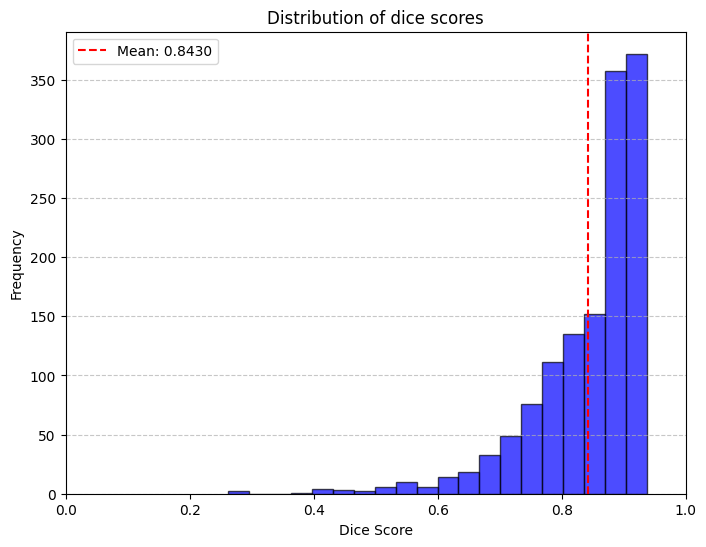

In [4]:
# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    with open("data\Heart\dice_2_scores.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of dice scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(bottom=0)
    plt.xlim(0,1)
    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {avg_dice:.4f}')
    plt.legend()
    

    # Plot speichern und anzeigen
    plt.savefig('data\Heart\dice_score_automatisch_2_histogram.png')
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")



2025-09-04 15:09:38,781 - INFO - la_003_slice_06_segmentation.png: HD=15.000 mm | HD95=10.000 mm (spacing=(1.25, 1.25))
2025-09-04 15:09:38,808 - INFO - la_003_slice_02_segmentation.png: HD=12.870 mm | HD95=11.250 mm (spacing=(1.25, 1.25))
2025-09-04 15:09:38,825 - INFO - la_003_slice_04_segmentation.png: HD=15.462 mm | HD95=11.264 mm (spacing=(1.25, 1.25))
2025-09-04 15:09:38,838 - INFO - la_003_slice_03_segmentation.png: HD=12.870 mm | HD95=8.839 mm (spacing=(1.25, 1.25))
2025-09-04 15:09:38,853 - INFO - la_003_slice_01_segmentation.png: HD=12.748 mm | HD95=10.866 mm (spacing=(1.25, 1.25))
2025-09-04 15:09:38,887 - INFO - la_003_slice_07_segmentation.png: HD=15.910 mm | HD95=11.250 mm (spacing=(1.25, 1.25))
2025-09-04 15:09:38,962 - INFO - la_003_slice_05_segmentation.png: HD=13.463 mm | HD95=10.000 mm (spacing=(1.25, 1.25))
2025-09-04 15:09:39,050 - INFO - la_003_slice_08_segmentation.png: HD=18.750 mm | HD95=13.750 mm (spacing=(1.25, 1.25))
2025-09-04 15:09:41,086 - INFO - la_003_s

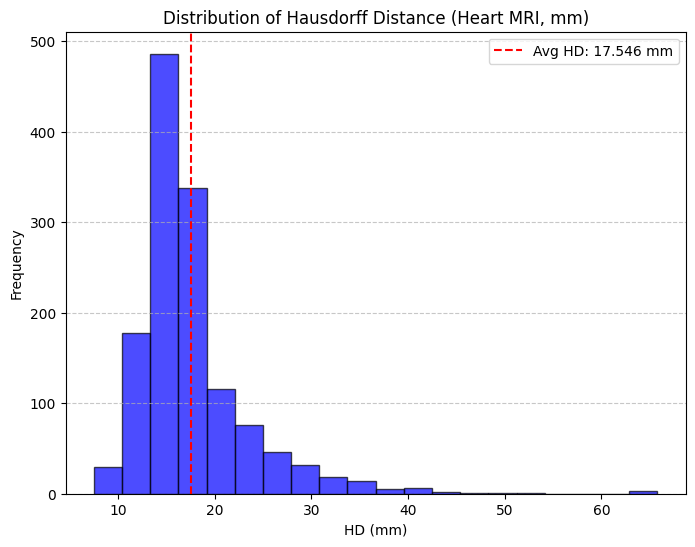

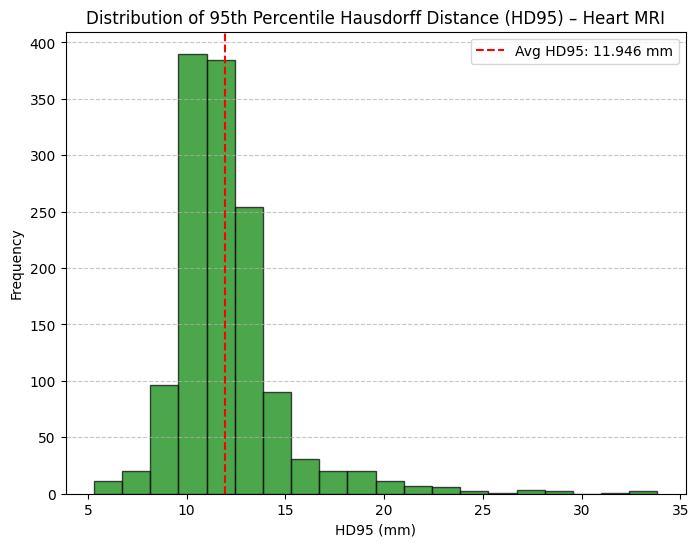

In [1]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from scipy import ndimage as ndi
import nibabel as nib

# ---------------- Logging ----------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ---------------- Pfade ----------------
mask_png_folder = os.path.join("data", "Heart", "output_masks_updated")
segmentation_results_folder = os.path.join("data", "Heart", "segmentation_2_results")
nii_root = os.path.join("data", "Heart", "output_images")  # <— deine NIfTIs liegen nur hier

# ---------------- Spacing-Cache ----------------
_spacing_cache = {}  # base_name -> (dy, dx) in mm

def _get_spacing_dy_dx(base_name: str):
    """Hole (dy, dx) in mm aus NIfTI-Header im output_images-Ordner."""
    if base_name in _spacing_cache:
        return _spacing_cache[base_name]

    nii_path = os.path.join(nii_root, f"{base_name}.nii.gz")
    if not os.path.exists(nii_path):
        logging.warning(f"Kein NIfTI für {base_name} gefunden → spacing=(1.0,1.0)")
        _spacing_cache[base_name] = (1.0, 1.0)
        return _spacing_cache[base_name]

    nii = nib.load(nii_path)
    zooms = nii.header.get_zooms()
    dx, dy = float(zooms[0]), float(zooms[1])  # NIfTI gibt (dx,dy,dz,...)
    _spacing_cache[base_name] = (dy, dx)       # für 2D-EDT: (dy,dx)
    return _spacing_cache[base_name]

# ---------------- HD/HD95 Hilfsfunktionen ----------------
def _bin2d(a):
    return (a > 0).astype(np.uint8)

def _surface(mask):
    if mask.sum() == 0:
        return mask.astype(bool)
    eroded = ndi.binary_erosion(mask, iterations=1, border_value=0)
    return mask.astype(bool) & (~eroded)

def _surface_distances_2d(A, B, spacing):
    if B.sum() == 0:
        d = np.full(A.shape, np.inf, dtype=float)
    else:
        d = ndi.distance_transform_edt(~B.astype(bool), sampling=spacing)
    return d[_surface(A)]

def hausdorff_2d(mask1, mask2, spacing, percentile=None):
    a = _bin2d(mask1); b = _bin2d(mask2)
    if a.sum() == 0 and b.sum() == 0:
        return 0.0
    if a.sum() == 0 or b.sum() == 0:
        return float("inf")
    d_ab = _surface_distances_2d(a, b, spacing)
    d_ba = _surface_distances_2d(b, a, spacing)
    all_d = np.concatenate([d_ab, d_ba])
    if all_d.size == 0:
        return 0.0
    return float(np.max(all_d) if percentile is None else np.percentile(all_d, percentile))

# ---------------- Einzeldatei-Verarbeitung ----------------
def process_single_file_hd(mask_filename: str):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    slice_number_converted = int(slice_number) - 1
    seg_name = f"{base_name}.nii.gz_slice_{slice_number_converted}_segmentation.png"

    mask_path = os.path.join(mask_png_folder, mask_filename)
    seg_path  = os.path.join(segmentation_results_folder, seg_name)

    if not os.path.exists(seg_path):
        logging.warning(f"Segmentationsdatei für {mask_filename} nicht gefunden!")
        return None

    spacing = _get_spacing_dy_dx(base_name)

    m_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    s_img = cv2.imread(seg_path,  cv2.IMREAD_GRAYSCALE)
    if m_img is None or s_img is None:
        logging.error(f"Fehler beim Laden: {mask_filename}")
        return None

    if m_img.shape != s_img.shape:
        logging.warning(f"Resize {base_name} slice {slice_number}: {s_img.shape} -> {m_img.shape}")
        s_img = cv2.resize(s_img, (m_img.shape[1], m_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    m_bin = (m_img > 0).astype(np.uint8)
    s_bin = (s_img > 0).astype(np.uint8)

    hd   = hausdorff_2d(m_bin, s_bin, spacing=spacing, percentile=None)
    hd95 = hausdorff_2d(m_bin, s_bin, spacing=spacing, percentile=95)

    logging.info(f"{mask_filename}: HD={hd:.3f} mm | HD95={hd95:.3f} mm (spacing={spacing})")
    return mask_filename, hd, hd95

# ---------------- Parallelisieren & Sammeln ----------------
results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_single_file_hd, fn)
        for fn in os.listdir(mask_png_folder)
        if fn.endswith(".png")
    ]
    results = [f.result() for f in futures if f.result() is not None]

# ---------------- Speichern & Visualisieren ----------------
if results:
    csv_path = os.path.join("data", "Heart", "hausdorff_2_results.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Maskenname", "Hausdorff_mm", "HD95_mm"])
        writer.writerows(results)
    logging.info(f"CSV gespeichert: {csv_path}")

    hd_vals   = [r[1] for r in results if np.isfinite(r[1])]
    hd95_vals = [r[2] for r in results if np.isfinite(r[2])]

    avg_hd   = np.mean(hd_vals)   if hd_vals   else None
    avg_hd95 = np.mean(hd95_vals) if hd95_vals else None

    if hd_vals:
        plt.figure(figsize=(8, 6))
        plt.hist(hd_vals, bins=20, color='blue', alpha=0.7, edgecolor='black')
        plt.title('Distribution of Hausdorff Distance (Heart MRI, mm)')
        plt.xlabel('HD (mm)'); plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        if avg_hd is not None:
            plt.axvline(avg_hd, color='red', linestyle='dashed', linewidth=1.5,
                        label=f'Avg HD: {avg_hd:.3f} mm')
            plt.legend()
        plt.savefig(os.path.join("data", "Heart", "hausdorff_hist_heart_mri.png"),
                    dpi=150, bbox_inches='tight')
        plt.show()

    if hd95_vals:
        plt.figure(figsize=(8, 6))
        plt.hist(hd95_vals, bins=20, color='green', alpha=0.7, edgecolor='black')
        plt.title('Distribution of 95th Percentile Hausdorff Distance (HD95) – Heart MRI')
        plt.xlabel('HD95 (mm)'); plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        if avg_hd95 is not None:
            plt.axvline(avg_hd95, color='red', linestyle='dashed', linewidth=1.5,
                        label=f'Avg HD95: {avg_hd95:.3f} mm')
            plt.legend()
        plt.savefig(os.path.join("data", "Heart", "hausdorff95_hist_heart_mri.png"),
                    dpi=150, bbox_inches='tight')
        plt.show()
else:
    logging.info("Keine HD/HD95-Werte berechnet!")


2025-09-04 15:22:26,048 - INFO - la_003_slice_02_segmentation.png: IoU = 0.4338
2025-09-04 15:22:26,093 - INFO - la_003_slice_05_segmentation.png: IoU = 0.6344
2025-09-04 15:22:26,124 - INFO - la_003_slice_01_segmentation.png: IoU = 0.2926
2025-09-04 15:22:26,130 - INFO - la_003_slice_04_segmentation.png: IoU = 0.5363
2025-09-04 15:22:26,136 - INFO - la_003_slice_06_segmentation.png: IoU = 0.6628
2025-09-04 15:22:26,161 - INFO - la_003_slice_03_segmentation.png: IoU = 0.5810
2025-09-04 15:22:26,222 - INFO - la_003_slice_12_segmentation.png: IoU = 0.7326
2025-09-04 15:22:26,223 - INFO - la_003_slice_07_segmentation.png: IoU = 0.6713
2025-09-04 15:22:26,260 - INFO - la_003_slice_10_segmentation.png: IoU = 0.6833
2025-09-04 15:22:26,251 - INFO - la_003_slice_09_segmentation.png: IoU = 0.6439
2025-09-04 15:22:26,257 - INFO - la_003_slice_08_segmentation.png: IoU = 0.6249
2025-09-04 15:22:26,236 - INFO - la_003_slice_11_segmentation.png: IoU = 0.7134
2025-09-04 15:22:26,348 - INFO - la_003_

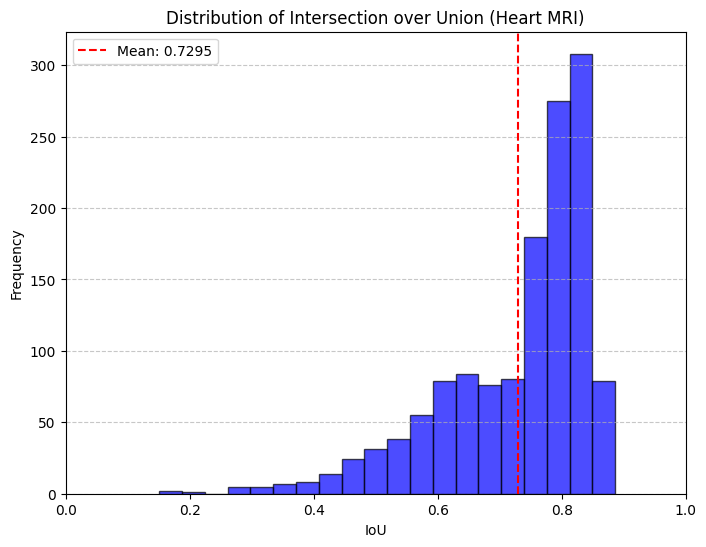

2025-09-04 15:22:53,517 - INFO - IoU-Histogramm gespeichert: data\Heart\iou_hist_heart_mri.png


In [2]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# ---------------- Logging ----------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ---------------- Pfade ----------------
mask_png_folder = os.path.join("data", "Heart", "output_masks_updated")
segmentation_results_folder = os.path.join("data", "Heart", "segmentation_2_results")

# ---------------- IoU ----------------
def iou_2d(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Intersection over Union für 2D-Binärmasken.
    IoU = |A ∩ B| / |A ∪ B|
    Sonderfall: beide leer -> IoU = 1.0
    """
    a = (mask1 > 0).astype(np.uint8)
    b = (mask2 > 0).astype(np.uint8)
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    if union == 0:
        return 1.0
    return inter / union

# ---------------- Einzeldatei-Verarbeitung ----------------
def process_single_file_iou(mask_filename: str):
    """
    Erwartet Masken:     <base>_slice_{N}_mask.png
    Sucht Segmentierung: <base>.nii.gz_slice_{N-1}_segmentation.png
    (gleiches Schema wie in deinen anderen Skripten)
    """
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    slice_number_converted = int(slice_number) - 1
    seg_name = f"{base_name}.nii.gz_slice_{slice_number_converted}_segmentation.png"

    mask_path = os.path.join(mask_png_folder, mask_filename)
    seg_path  = os.path.join(segmentation_results_folder, seg_name)

    if not os.path.exists(seg_path):
        logging.warning(f"Segmentationsdatei für {mask_filename} nicht gefunden!")
        return None

    try:
        # Laden
        m_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        s_img = cv2.imread(seg_path,  cv2.IMREAD_GRAYSCALE)
        if m_img is None or s_img is None:
            logging.error(f"Fehler beim Laden: {mask_filename}")
            return None

        # ggf. Shape angleichen
        if m_img.shape != s_img.shape:
            logging.warning(f"Resize {base_name} slice {slice_number}: {s_img.shape} -> {m_img.shape}")
            s_img = cv2.resize(s_img, (m_img.shape[1], m_img.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Binär & IoU
        iou_val = iou_2d(m_img, s_img)
        logging.info(f"{mask_filename}: IoU = {iou_val:.4f}")
        return mask_filename, float(iou_val)

    except Exception as e:
        logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
        return None

# ---------------- Parallelisieren & Sammeln ----------------
iou_results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_single_file_iou, fn)
        for fn in os.listdir(mask_png_folder)
        if fn.endswith(".png")
    ]
    iou_results = [f.result() for f in futures if f.result() is not None]

# ---------------- Speichern & Visualisieren ----------------
if iou_results:
    # CSV
    csv_path = os.path.join("data", "Heart", "iou_2_results.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Maskenname", "IoU"])
        writer.writerows(iou_results)
    logging.info(f"CSV gespeichert: {csv_path}")

    # Histogramm
    iou_vals = [r[1] for r in iou_results]
    avg_iou = float(np.mean(iou_vals)) if iou_vals else None

    plt.figure(figsize=(8, 6))
    plt.hist(iou_vals, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Intersection over Union (Heart MRI)')
    plt.xlabel('IoU'); plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 1); plt.ylim(bottom=0)
    if avg_iou is not None:
        plt.axvline(avg_iou, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {avg_iou:.4f}')
        plt.legend()

    plot_path = os.path.join("data", "Heart", "iou_hist_heart_mri.png")
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    logging.info(f"IoU-Histogramm gespeichert: {plot_path}")
else:
    logging.info("Keine IoU-Werte berechnet!")


2025-09-04 15:25:17,315 - INFO - la_003_slice_01_segmentation.png: Surface Dice (1.0 mm) = 0.2183 (spacing=(1.25, 1.25))
2025-09-04 15:25:17,420 - INFO - la_003_slice_02_segmentation.png: Surface Dice (1.0 mm) = 0.2225 (spacing=(1.25, 1.25))
2025-09-04 15:25:17,461 - INFO - la_003_slice_03_segmentation.png: Surface Dice (1.0 mm) = 0.2751 (spacing=(1.25, 1.25))
2025-09-04 15:25:17,476 - INFO - la_003_slice_04_segmentation.png: Surface Dice (1.0 mm) = 0.2986 (spacing=(1.25, 1.25))
2025-09-04 15:25:17,600 - INFO - la_003_slice_05_segmentation.png: Surface Dice (1.0 mm) = 0.3091 (spacing=(1.25, 1.25))
2025-09-04 15:25:17,842 - INFO - la_003_slice_06_segmentation.png: Surface Dice (1.0 mm) = 0.3713 (spacing=(1.25, 1.25))
2025-09-04 15:25:18,063 - INFO - la_003_slice_07_segmentation.png: Surface Dice (1.0 mm) = 0.3281 (spacing=(1.25, 1.25))
2025-09-04 15:25:18,421 - INFO - la_003_slice_09_segmentation.png: Surface Dice (1.0 mm) = 0.3066 (spacing=(1.25, 1.25))
2025-09-04 15:25:18,452 - INFO -

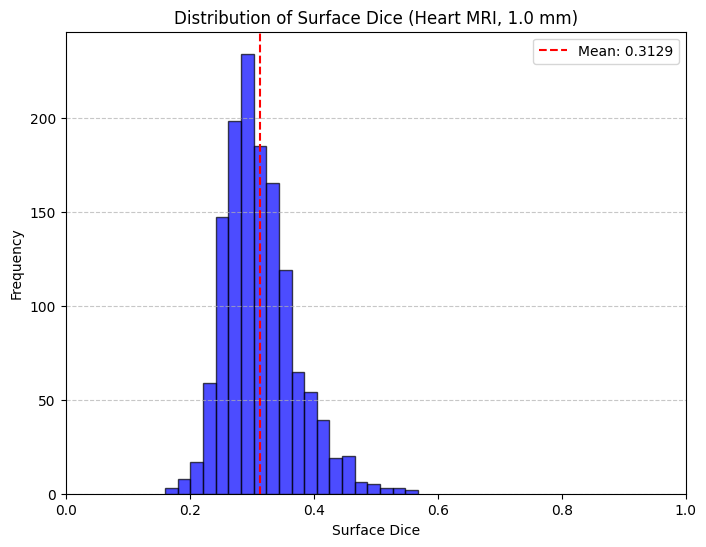

2025-09-04 15:29:11,723 - INFO - Surface-Dice-Histogramm gespeichert: data\Heart\surface_dice_hist_1_0mm_heart_mri.png


In [3]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from scipy import ndimage as ndi
import nibabel as nib

# ---------------- Logging ----------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ---------------- Pfade ----------------
mask_png_folder = os.path.join("data", "Heart", "output_masks_updated")
segmentation_results_folder = os.path.join("data", "Heart", "segmentation_2_results")
nii_root = os.path.join("data", "Heart", "output_images")  # NIfTIs liegen nur hier

# ---------------- Parameter ----------------
tolerance_mm = 1.0  # z.B. 1.0 oder 2.0

# ---------------- Spacing-Cache ----------------
_spacing_cache = {}  # base_name -> (dy, dx) in mm

def _get_spacing_dy_dx(base_name: str):
    """Hole (dy, dx) in mm aus <nii_root>/<base_name>.nii.gz; Fallback (1,1) mit Warnung."""
    if base_name in _spacing_cache:
        return _spacing_cache[base_name]
    nii_path = os.path.join(nii_root, f"{base_name}.nii.gz")
    if not os.path.exists(nii_path):
        logging.warning(f"Kein NIfTI für {base_name} gefunden → spacing=(1.0,1.0)")
        _spacing_cache[base_name] = (1.0, 1.0)
        return _spacing_cache[base_name]
    nii = nib.load(nii_path)
    dx, dy = float(nii.header.get_zooms()[0]), float(nii.header.get_zooms()[1])  # (dx,dy, ...)
    _spacing_cache[base_name] = (dy, dx)  # EDT erwartet (dy, dx)
    return _spacing_cache[base_name]

# ---------------- Surface-Dice Hilfsfunktionen ----------------
def _bin2d(a: np.ndarray) -> np.ndarray:
    if a.ndim != 2:
        raise ValueError("Erwarte 2D-Maske.")
    return (a > 0).astype(np.uint8)

def _surface(mask: np.ndarray) -> np.ndarray:
    if mask.sum() == 0:
        return mask.astype(bool)
    eroded = ndi.binary_erosion(mask, iterations=1, border_value=0)
    return mask.astype(bool) & (~eroded)

def surface_dice_2d(pred: np.ndarray, gt: np.ndarray, spacing, tol_mm: float) -> float:
    """
    Anteil der Oberflächenpunkte beider Masken, deren Abstand zur jeweils anderen
    Oberfläche <= tol_mm ist. Ergebnis in [0,1].
    """
    p = _bin2d(pred); g = _bin2d(gt)
    ps = _surface(p); gs = _surface(g)

    # Sonderfälle
    if p.sum() == 0 and g.sum() == 0:
        return 1.0
    if ps.sum() == 0 and gs.sum() == 0:
        return 1.0
    if ps.sum() == 0 or gs.sum() == 0:
        return 0.0

    d_to_g = ndi.distance_transform_edt(~g.astype(bool), sampling=spacing)
    d_to_p = ndi.distance_transform_edt(~p.astype(bool), sampling=spacing)

    p_ok = (d_to_g[ps] <= tol_mm).sum()
    g_ok = (d_to_p[gs] <= tol_mm).sum()
    return (p_ok + g_ok) / (ps.sum() + gs.sum())

# ---------------- Einzeldatei-Verarbeitung ----------------
def process_single_file_surface_dice(mask_filename: str):
    """
    Erwartet Maske:         <base>_slice_{N}_mask.png
    Sucht Segmentierung:    <base>.nii.gz_slice_{N-1}_segmentation.png  (dein Schema)
    """
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    slice_number_converted = int(slice_number) - 1
    seg_name = f"{base_name}.nii.gz_slice_{slice_number_converted}_segmentation.png"

    mask_path = os.path.join(mask_png_folder, mask_filename)
    seg_path  = os.path.join(segmentation_results_folder, seg_name)

    if not os.path.exists(seg_path):
        logging.warning(f"Segmentationsdatei für {mask_filename} nicht gefunden!")
        return None

    spacing = _get_spacing_dy_dx(base_name)

    m_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    s_img = cv2.imread(seg_path,  cv2.IMREAD_GRAYSCALE)
    if m_img is None or s_img is None:
        logging.error(f"Fehler beim Laden: {mask_filename}")
        return None

    if m_img.shape != s_img.shape:
        logging.warning(f"Resize {base_name} slice {slice_number}: {s_img.shape} -> {m_img.shape}")
        s_img = cv2.resize(s_img, (m_img.shape[1], m_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    m_bin = (m_img > 0).astype(np.uint8)
    s_bin = (s_img > 0).astype(np.uint8)

    sd = surface_dice_2d(s_bin, m_bin, spacing=spacing, tol_mm=tolerance_mm)
    logging.info(f"{mask_filename}: Surface Dice ({tolerance_mm} mm) = {sd:.4f} (spacing={spacing})")
    return mask_filename, float(sd)

# ---------------- Parallelisieren & Sammeln ----------------
sd_results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_single_file_surface_dice, fn)
        for fn in os.listdir(mask_png_folder)
        if fn.endswith(".png")
    ]
    sd_results = [f.result() for f in futures if f.result() is not None]

# ---------------- Speichern & Visualisieren ----------------
if sd_results:
    csv_name = os.path.join("data", "Heart", f"surface_dice_{str(tolerance_mm).replace('.','_')}mm_results.csv")
    with open(csv_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Maskenname", f"SurfaceDice_{tolerance_mm}mm"])
        writer.writerows(sd_results)
    logging.info(f"CSV gespeichert: {csv_name}")

    sd_vals = [r[1] for r in sd_results]
    avg_sd = float(np.mean(sd_vals)) if sd_vals else None

    plt.figure(figsize=(8, 6))
    plt.hist(sd_vals, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Surface Dice (Heart MRI, {tolerance_mm} mm)')
    plt.xlabel('Surface Dice')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 1); plt.ylim(bottom=0)
    if avg_sd is not None:
        plt.axvline(avg_sd, color='red', linestyle='dashed', linewidth=1.5,
                    label=f'Mean: {avg_sd:.4f}')
        plt.legend()

    plot_path = os.path.join("data", "Heart", f"surface_dice_hist_{str(tolerance_mm).replace('.','_')}mm_heart_mri.png")
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    logging.info(f"Surface-Dice-Histogramm gespeichert: {plot_path}")
else:
    logging.info("Keine Surface-Dice-Werte berechnet!")
